In [15]:
import math
import numpy
import time
from matplotlib import pyplot
%matplotlib inline

In [2]:
pyplot.rcParams['font.family'] = 'serif'
pyplot.rcParams['font.size'] = 16

In [3]:
g = 9.81
vt = 4.9
CD = 1.0/5.0
CL = 1.0

v0 = 6.5
theta0 = -0.1
x0 = 0.0
y0 = 2.0

In [4]:
def rhs_phugoid(u, CL, CD, g, vt):
    v, theta, x, y = u
    rhs = numpy.array([-g*math.sin(theta) - CD/CL * g / vt**2 * v**2,
                       -g * math.cos(theta) / v + g / vt**2 * v,
                       v * math.cos(theta),
                       v * math.sin(theta)])
    return rhs

def euler_step(u, f, dt, *args):
    u_new = u + dt * f(u, *args) ## Python can understand that f is a function
    return u_new                 ## Function can be called when euler_step is called

def l1_diff(u_coarse, u_fine, dt):
    N_coarse = u_coarse.shape[0]
    N_fine = u_fine.shape[0]
    ratio = math.ceil(N_fine / N_coarse)
    diff = dt * numpy.sum(numpy.abs(u_coarse - u_fine[::ratio]))
    return diff

def rk2_step(u, f, dt, *args):
    u_star = u + 0.5 * dt * f(u, *args)
    u_new = u + dt * f(u_star, *args)
    return u_new

In [5]:
T = 15.0
dt = 0.01
N = int(T/dt) + 1

# Array to store solution
u_euler = numpy.empty((N, 4))
u_rk2 = numpy.empty((N, 4))

# Initial Conditions
u_euler[0] = numpy.array([v0, theta0, x0, y0])
u_rk2[0] = numpy.array([v0, theta0, x0, y0])

#Time Integration
for n in range(N - 1):
    u_euler[n + 1] = euler_step(u_euler[n], rhs_phugoid, dt, CL, CD, g, vt)
    u_rk2[n+1] = rk2_step(u_rk2[n], rhs_phugoid, dt, CL, CD, g, vt)
    

In [6]:
#determine position by grabbing values from array
x_euler = u_euler[:, 2]
y_euler = u_euler[:, 3]
x_rk2 = u_rk2[:, 2]
y_rk2 = u_rk2[:, 3]

In [7]:
## Find the first negative index
#numpy.where determines the index of the specified value
idx_negative_euler = numpy.where(y_euler < 0.0)[0]
if len(idx_negative_euler) == 0:
    idx_ground_euler = N - 1
    print('[Euler] Glider has not touched the ground yet!')
else:
    idx_ground_euler = idx_negative_euler[0]

# Find the first negative of y_rk2
idx_negative_rk2 = numpy.where(y_rk2 < 0.0)[0]
if len(idx_negative_rk2) == 0:
    idx_ground_rk2 = N - 1
    print('[Euler] Glider has not touched the ground yet!')
else:
    idx_ground_rk2 = idx_negative_rk2[0]

In [8]:
##Numpy has a built in checker
print('Are the x values close? {}'.format(numpy.allclose(x_euler, x_rk2)))
print('Are the y values close? {}'.format(numpy.allclose(y_euler, y_rk2)))

Are the x values close? False
Are the y values close? False


Distance Traveled: 14.516


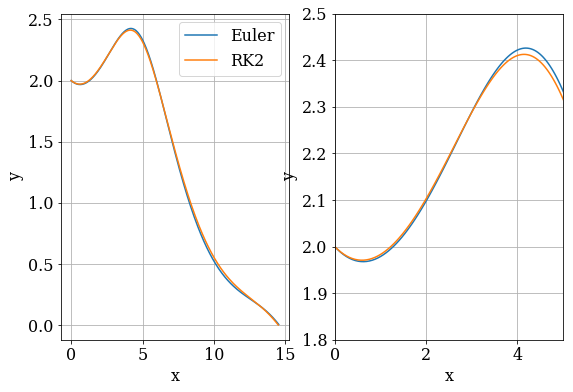

In [9]:
print('Distance Traveled: {:.3f}'.format(x_rk2[idx_ground_rk2 - 1]))

pyplot.figure(figsize=(9.0, 6.0))
pyplot.subplot(121)
pyplot.grid()
pyplot.xlabel('x')
pyplot.ylabel('y')
pyplot.plot(x_euler[:idx_ground_euler], y_euler[:idx_ground_euler],
            label='Euler')
pyplot.plot(x_rk2[:idx_ground_rk2], y_rk2[:idx_ground_rk2],
            label='RK2')
pyplot.legend();
# Let's take a closer look!
pyplot.subplot(122)
pyplot.grid()
pyplot.xlabel('x')
pyplot.ylabel('y')
pyplot.plot(x_euler, y_euler, label='Euler')
pyplot.plot(x_rk2, y_rk2, label='RK2')
pyplot.xlim(0.0, 5.0)
pyplot.ylim(1.8, 2.5);

In [10]:
dt_values = [0.1, 0.05, 0.01, 0.005, 0.001]

u_values = [] #how to create an empty list

for dt in dt_values:
    N = int(T/dt) + 1
    u = numpy.empty((N, 4))
    u[0] = numpy.array([v0, theta0, x0, y0])
    
    for n in range(N-1):
        u[n+1] = rk2_step(u[n], rhs_phugoid, dt, CL, CD, g, vt)
    u_values.append(u)

In [11]:
diff_values = []
for u, dt, in zip(u_values, dt_values):
    diff = l1_diff(u[:, 2], u_values[-1][:, 2], dt)
    diff_values.append(diff)

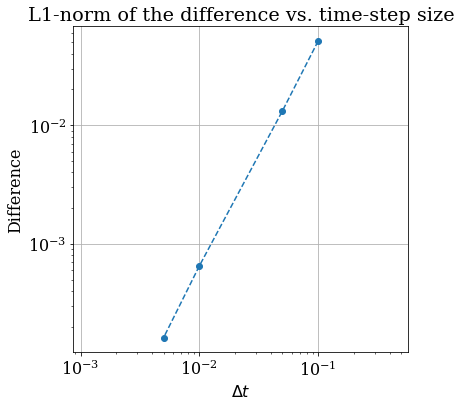

In [12]:
pyplot.figure(figsize=(6.0, 6.0))
pyplot.title('L1-norm of the difference vs. time-step size')
pyplot.xlabel('$\Delta t$')
pyplot.ylabel('Difference')
pyplot.grid()
pyplot.loglog(dt_values[:-1], diff_values[:-1],
              color='C0', linestyle='--', marker='o')
pyplot.axis('equal');

In [14]:
r = 2 #time-step size refinement ratio
h = 0.001 #finest time-step size

dt_values = [h, r * h, r**2 *h]
u_values = []

for dt in dt_values:
    N = int(T/dt) + 1
    u = numpy.empty((N, 4))
    u[0] = numpy.array([v0, theta0, x0, y0])
    for n in range(N - 1):
        u[n + 1] = rk2_step(u[n], rhs_phugoid, dt, CL, CD, g, vt)
    u_values.append(u)
    
p = (math.log(l1_diff(u_values[2], u_values[1], dt_values[2]) /
              l1_diff(u_values[1], u_values[0], dt_values[1])) /
     math.log(r))

print('Observed orger of convergence: p = {:.3f}'.format(p))

Observed orger of convergence: p = 1.996


In [16]:
rk2_start = time.time()

for dt in dt_values:
    N = int(T/dt) + 1
    u = numpy.empty((N, 4))
    u[0] = numpy.array([v0, theta0, x0, y0])
    for n in range(N - 1):
        u[n + 1] = rk2_step(u[n], rhs_phugoid, dt, CL, CD, g, vt)
    u_values.append(u)
    
rk2_stop = time.time()
rk2_run = rk2_stop - rk2_start
rk2_run

0.6644182205200195

In [17]:
euler_start = time.time()

for dt in dt_values:
    N = int(T/dt) + 1
    u = numpy.empty((N, 4))
    u[0] = numpy.array([v0, theta0, x0, y0])
    for n in range(N - 1):
        u[n + 1] = euler_step(u[n], rhs_phugoid, dt, CL, CD, g, vt)
    u_values.append(u)
    
euler_stop = time.time()

euler_run = euler_stop - euler_start
euler_run

0.34365296363830566

In [22]:
def leapfrog_step(u_prev, u, f, dt, *args):
    u_new = u_prev + 2.0 * dt * f(u, *args)
    return u_new

In [23]:
##Multistep functions like the leap frog require an initial kick
g = 9.81  
vt = 4.9 
CD = 1.0 / 5.0  
CL = 1.0  

# Set initial conditions.
v0 = 6.5  
theta0 = -0.1 
x0 = 0.0 
y0 = 2.0  

T = 15.0  
dt = 0.01  
N = int(T / dt) + 1  

u_leapfrog = numpy.empty((N, 4))
u_leapfrog[0] = numpy.array([v0, theta0, x0, y0])
u_leapfrog[1] = rk2_step(u_leapfrog[0], rhs_phugoid, dt, CL, CD, g, vt)

In [24]:
for n in range(1, N - 1):
    u_leapfrog[n + 1] = leapfrog_step(u_leapfrog[n - 1], u_leapfrog[n], rhs_phugoid, dt, CL, CD, g, vt)

In [25]:
x_leapfrog = u_leapfrog[:, 2]
y_leapfrog = u_leapfrog[:, 3]

idx_negative_leapfrog = numpy.where(y_leapfrog < 0.0)[0]
if len(idx_negative_leapfrog) == 0:
    idx_ground_leapfrog = N - 1
    print('[leapfrog] Glider has not touched ground yet!')
else:
    idx_ground_leapfrog = idx_negative_leapfrog[0]

Distance traveled: 14.516


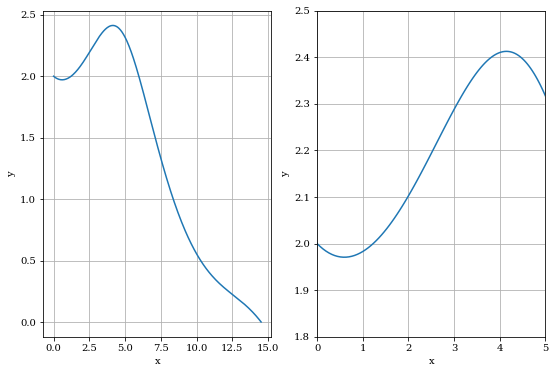

In [26]:
print('Distance traveled: {:.3f}'.format(x_leapfrog[idx_ground_leapfrog - 1]))

# Plot the glider's path for the leapfrog scheme.
pyplot.figure(figsize=(9.0, 6.0))
pyplot.subplot(121)
pyplot.grid()
pyplot.xlabel('x')
pyplot.ylabel('y')
pyplot.plot(x_leapfrog[:idx_ground_leapfrog],
            y_leapfrog[:idx_ground_leapfrog])
# Let's take a closer look!
pyplot.subplot(122)
pyplot.grid()
pyplot.xlabel('x')
pyplot.ylabel('y')
pyplot.plot(x_leapfrog, y_leapfrog)
pyplot.xlim(0.0, 5.0)
pyplot.ylim(1.8, 2.5);

In [28]:
r = 2  
h = 0.001 

dt_values = [h, r * h, r**2 * h]
u_values = []

for dt in dt_values:
    N = int(T / dt) + 1  
    u = numpy.empty((N, 4))
    u[0] = numpy.array([v0, theta0, x0, y0])
    u[1] = rk2_step(u[0], rhs_phugoid, dt, CL, CD, g, vt)
    for n in range(1, N - 1):
        u[n + 1] = leapfrog_step(u[n - 1], u[n], rhs_phugoid, dt,
                                 CL, CD, g, vt)
    u_values.append(u)

# Compute the observed order of convergence.
p = (math.log(l1_diff(u_values[2][:, 2], u_values[1][:, 2],
                      dt_values[2]) /
              l1_diff(u_values[1][:, 2], u_values[0][:, 2],
                      dt_values[1])) /
     math.log(r))

print('Observed order of convergence: p = {:.3f}'.format(p))

Observed order of convergence: p = 2.187
